In [ ]:
!pip install plotly==4.14.3
!pip install plotly-geo
!pip install geopandas
!pip install pyshp
!pip install shapely

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd

path = '/content/gdrive/MyDrive/CLPS0950/CLPSProject2/Data/'
US_countyinfo = df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
pa_racedata = pd.read_csv('https://raw.githubusercontent.com/desmondg19/CLPSProject2/main/COVID-19_Vaccinations_by_Race_Current_County_Health%20(3).csv')

#Note for next line - there is an error in the spelling of the pa_racedata column which next line fixes
pa_racedata.rename(columns={'Partially Covered  Unknown': 'Partially Covered Unknown'}, inplace=True)

Mounted at /content/gdrive


In [5]:
#Filling all the blank spots with zero
pa_racedata.fillna(0, inplace = True)

#Made two new columns with sums of vaccinations for all non-white populations in PA and all people
pa_racedata['Partially Covered Non-White'] = pa_racedata['Partially Covered African American'] + pa_racedata['Partially Covered Asian'] + pa_racedata['Partially Covered Native American'] + pa_racedata['Partially Covered Pacific Islander'] 
pa_racedata['Partially Covered'] = pa_racedata['Partially Covered Non-White'] + pa_racedata['Partially Covered Unknown'] + pa_racedata['Partially Covered White'] + pa_racedata['Partially Covered Multiple Other']
pa_racedata['Fully Covered Non-White'] = pa_racedata['Fully Covered African American'] + pa_racedata['Fully Covered Asian'] + pa_racedata['Fully Covered Native American'] + pa_racedata['Fully Covered Pacific Islander']
pa_racedata['Fully Covered'] = pa_racedata['Fully Covered Non-White'] + pa_racedata['Fully Covered Unknown'] + pa_racedata['Fully Covered White'] + pa_racedata['Fully Covered Multiple Other']
pa_racedata['Partially or Fully Covered'] = pa_racedata['Fully Covered'] + pa_racedata['Partially Covered']

#Filtered the county info table to PA only and changed the value of county column so it matched racedata
pa_countyinfo = US_countyinfo[US_countyinfo['STNAME'] == 'Pennsylvania']
pa_countyinfo['CTYNAME'] = pa_countyinfo['CTYNAME'].str.replace(' County','', regex=True)

#Dropped the row that had data about out of state vaccinations
pa_race_instate = pa_racedata.drop(67,axis=0)

#Renamed the county name columns to be the same in the two df's so I could merge them
pa_countyinfo.rename(columns={'CTYNAME': 'County Name'}, inplace=True)
print(pa_countyinfo.columns.values[2] == 'County Name')

#Merging the Data
pa_countyinfo.reset_index(drop=True, inplace=True)
pa_race_instate.reset_index(drop=True, inplace=True)
pa_race_covid = pd.merge(pa_race_instate, pa_countyinfo, on = 'County Name')

True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
#Calculating the Percent of White/Non-White People Vaccinated and Generating New Columns
pa_race_covid['Percent Partially Covered Non-White'] = pa_race_covid['Partially Covered Non-White']/pa_race_covid['Not_NHWhite_Alone'] * 100
pa_race_covid['Percent Fully Covered Non-White'] = pa_race_covid['Fully Covered Non-White']/pa_race_covid['Not_NHWhite_Alone'] * 100
pa_race_covid['Percent Partially Covered White'] = pa_race_covid['Partially Covered White']/pa_race_covid['NHWhite_Alone'] * 100
pa_race_covid['Percent Fully Covered White'] = pa_race_covid['Fully Covered White']/pa_race_covid['NHWhite_Alone'] * 100
pa_race_covid['Percent Partially Covered'] = pa_race_covid['Partially Covered']/pa_race_covid['TOT_POP'] * 100
pa_race_covid['Percent Fully Covered'] = pa_race_covid['Fully Covered']/pa_race_covid['TOT_POP'] * 100
pa_race_covid['Percent Partially or Fully Covered'] = pa_race_covid['Partially or Fully Covered']/pa_race_covid['TOT_POP'] * 100

In [7]:
#Vaccination Choropleth Graphs - non-white, white, and all partial/full vaccination
import plotly.figure_factory as ff
import numpy as np

partvac_NW = pa_race_covid['Percent Partially Covered Non-White'].tolist()
fullvac_NW = pa_race_covid['Percent Fully Covered Non-White'].tolist()
partvac_W = pa_race_covid['Percent Partially Covered White'].tolist()
fullvac_W = pa_race_covid['Percent Fully Covered White'].tolist()
partvac = pa_race_covid['Percent Partially Covered'].tolist()
fullvac = pa_race_covid['Percent Fully Covered'].tolist()

pa_fips = pa_race_covid['FIPS'].tolist()

vaccine_endpts = list(np.mgrid[min(fullvac_NW):max(partvac):5j])

partvac_NW_fig = ff.create_choropleth(pa_fips, partvac_NW, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)',
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Non-White Partial Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='Non-White Partial Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
fullvac_NW_fig = ff.create_choropleth(pa_fips, fullvac_NW, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)', simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Non-White Full Vaccination Percentage',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='Non-White Full Vaccination by County',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
partvac_W_fig = ff.create_choropleth(pa_fips, partvac_W, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)', simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'White Partial Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='White Partial Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
fullvac_W_fig = ff.create_choropleth(pa_fips, fullvac_W, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts, simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'White Full Vaccination by County',
                           plot_bgcolor='rgb(229,229,229)',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='White Full Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
partvac_fig = ff.create_choropleth(pa_fips, partvac, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)',
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Partial Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='Partial Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
fullvac_fig = ff.create_choropleth(pa_fips, fullvac, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=vaccine_endpts,
                           plot_bgcolor='rgb(229,229,229)',
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Full Vaccination by County',
                           paper_bgcolor='rgb(229,229,229)',
                           legend_title='Full Vaccination Percentage',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})

partvac_NW_fig.show()
fullvac_NW_fig.show()
partvac_W_fig.show()
fullvac_W_fig.show()
partvac_fig.show()
fullvac_fig.show()

Output hidden; open in https://colab.research.google.com to view.

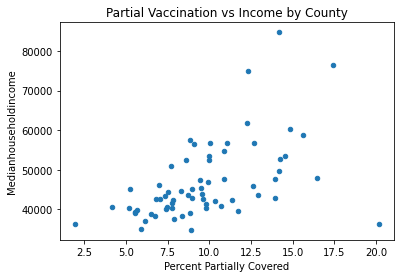

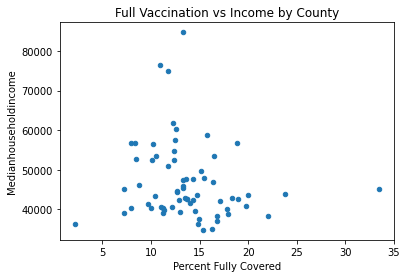

In [8]:
#Adding income related data from an HTML table
pa_tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_Pennsylvania_counties_by_per_capita_income')
pa_income = pa_tables[1]
pa_income.rename(columns={'County': 'County Name'}, inplace=True)

pa_income.reset_index(drop=True, inplace=True)
pa_race_covid.reset_index(drop=True, inplace=True)

pa_income_covid = pd.merge(pa_race_covid, pa_income, on = 'County Name')
pa_income_covid['Medianhouseholdincome'] = pa_income_covid['Medianhouseholdincome'].str.replace('$', '').str.replace(',', '')
pa_income_covid['Medianhouseholdincome'] = pa_income_covid['Medianhouseholdincome'].astype(int)

#Income Choropleth
incomes = pa_income_covid['Medianhouseholdincome'].tolist()
income_endpts = list(np.mgrid[min(incomes):max(incomes):5j])
incomes_fig = ff.create_choropleth(pa_fips, incomes, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=income_endpts,
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Median Household Income by County',
                           legend_title='Median Household Income ($)',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
incomes_fig.show()

#Income scatterplots
pa_income_covid.plot.scatter('Percent Partially Covered', 'Medianhouseholdincome', 
                             xlabel = 'Percent Partially Covered', ylabel = 'Median Household Income ($)',
                             title = 'Partial Vaccination vs Income by County')
pa_income_covid.plot.scatter('Percent Fully Covered', 'Medianhouseholdincome',
                             xlabel = 'Percent Fully Covered', ylabel = 'Median Household Income ($)',
                             title = 'Full Vaccination vs Income by County')

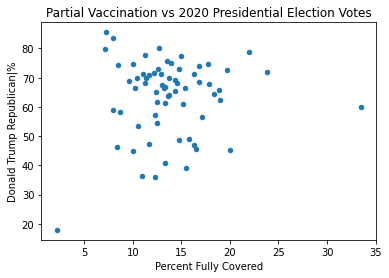

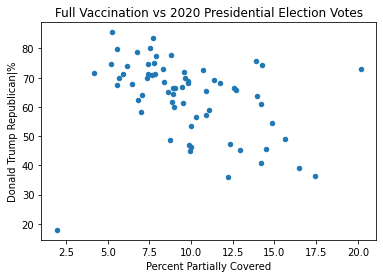

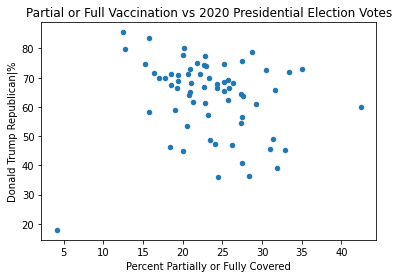

In [9]:
#Adding Election Related data from HTML table
pa_elections = pd.read_html('https://en.wikipedia.org/wiki/2020_United_States_presidential_election_in_Pennsylvania')
pa_pres_elections = pa_elections[32]

#Table was a two layered column header, so I had to compress to one level column
pa_pres_elections.columns = pa_pres_elections.columns.map(lambda x: '|'.join([str(i) for i in x]))

#Merging the tables
pa_pres_elections.reset_index(drop=True, inplace=True)
pa_income_covid.reset_index(drop=True, inplace=True)
pa_elections_covid = pd.merge(pa_income_covid, pa_pres_elections, left_on='County Name', right_on = pa_pres_elections['County|County'])
pa_elections_covid = pa_elections_covid.drop('County|County',axis=1)

#Converting data to a float, dropping percent
pa_elections_covid['Donald Trump Republican|%'] = pa_elections_covid['Donald Trump Republican|%'].str.replace('%', '')
pa_elections_covid['Donald Trump Republican|%'] = pa_elections_covid['Donald Trump Republican|%'].astype(float)

#Elections Choropleth
elections = pa_elections_covid['Donald Trump Republican|%'].tolist()
elections_endpts = list(np.mgrid[min(elections):max(elections):5j])
elections_fig = ff.create_choropleth(pa_fips, elections, scope=['Pennsylvania'], show_state_data=True, 
                           binning_endpoints=elections_endpts,
                           simplify_county = 0, simplify_state = 0,
                           show_hover = True, title = 'Percent Trump Votes by County',
                           legend_title='Percent Trump Votes',
                           county_outline={'color': 'rgb(255,255,255)', 'width': 0.2})
elections_fig.show()

#Elections Scatter Plot
pa_elections_covid.plot.scatter('Percent Fully Covered', 'Donald Trump Republican|%',
                                xlabel = 'Percent Partially Covered', ylabel = 'Percent Trump Votes',
                                title = 'Partial Vaccination vs 2020 Presidential Election Votes')
pa_elections_covid.plot.scatter('Percent Partially Covered', 'Donald Trump Republican|%',
                                xlabel = 'Percent Fully Covered', ylabel = 'Percent Trump Votes',
                                title = 'Full Vaccination vs 2020 Presidential Election Votes')
pa_elections_covid.plot.scatter('Percent Partially or Fully Covered', 'Donald Trump Republican|%',
                                ylabel = 'Percent Trump Votes',
                                title = 'Partial or Full Vaccination vs 2020 Presidential Election Votes')

In [ ]:
#Vaccination Rates Stacked Barplot by County
pa_elections_covid.plot(x = 'County Name', y = ["Percent Partially Covered Non-White", 
                                                "Percent Partially Covered White", 
                                                "Percent Fully Covered Non-White", 
                                                "Percent Partially Covered White"], 
                        kind = 'bar', stacked = True, fontsize = 10, figsize = (25, 10),
                        xlabel = 'County Name', ylabel = 'Percent Vaccinated',
                        title = 'Percent Vaccinated by County')

#Vaccination Rates Grouped Barplot by County - Erorr Bars do not work
error1 = pa_elections_covid['Percent Partially Covered Non-White'].std()
error2 = pa_elections_covid['Percent Partially Covered White'].std()

pa_elections_covid.plot(x = 'County Name', y = ["Percent Partially Covered Non-White", 
                                                "Percent Partially Covered White"], 
                        kind = 'bar', fontsize = 10, figsize = (25, 10),
                        xlabel = 'County Name', ylabel = 'Percent Partially Vaccinated', 
                        title = 'Percent Partially Vaccinated by County')

#Vaccination Scatterplots - White vs Non-White Vaccination Rates
pa_race_covid.plot.scatter('Percent Partially Covered Non-White', 'Percent Partially Covered White',
                        xlabel = 'Percent Partially Covered Non-White',
                        ylabel = 'Percent Partially Covered White', 
                        title = 'Comparing White and Non-White Partial Vaccination')
pa_race_covid.plot.scatter('Percent Fully Covered Non-White', 'Percent Fully Covered White',
                        xlabel = 'Percent Fully Covered Non-White',
                        ylabel = 'Percent Fully Covered White', 
                        title = 'Comparing White and Non-White Full Vaccination')

#Vaccination Histograms - White vs Non-White Vaccination Rates
pa_elections_covid.plot(x = 'County Name', y = "Percent Partially Covered Non-White",
                        kind = 'hist', xlabel = 'Percent Partially Covered Non-White',
                        ylabel = 'Frequency', 
                        title = 'Percent Non-White Partially Vaccinated by County')
pa_elections_covid.plot(x = 'County Name', y = "Percent Partially Covered White",
                        kind = 'hist', xlabel = 'Percent Partially Covered White',
                        ylabel = 'Frequency', 
                        title = 'Percent White Partially Vaccinated by County')
pa_elections_covid.plot(x = 'County Name', y = "Percent Fully Covered Non-White",
                        kind = 'hist', xlabel = 'Percent Fully Covered Non-White',
                        ylabel = 'Frequency', 
                        title = 'Percent Non-White Fully Vaccinated by County')
pa_elections_covid.plot(x = 'County Name', y = "Percent Fully Covered White",
                        kind = 'hist', xlabel = 'Percent Fully Covered White',
                        ylabel = 'Frequency', 
                        title = 'Percent White Fully Vaccinated by County')

In [63]:
#THIS CELL IS BUGGY - DO NOT RUN YET BC IT CRASHES COLAB
#Choropleth for the US
from urllib.request import urlopen
import json
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
state_data = pd.read_csv('https://raw.githubusercontent.com/desmondg19/CLPSProject2/main/Modified_PercentTotalPopulationReceivedVaccineRace_Ethnicity.csv')

df.reset_index(drop=True, inplace=True)
state_data.reset_index(drop=True, inplace=True)

state_data_wcodes = pd.merge(df[['code', 'state']], state_data, left_on='state', right_on = 'Location')
state_data_wcodes['White to Black Ratio'] = state_data_wcodes['White to Black Ratio'].str.replace('NR', '0')
state_data_wcodes['White to Hispanic Ratio'] = state_data_wcodes['White to Hispanic Ratio'].str.replace('NR', '0')
state_data_wcodes['White to Asian Ratio'] = state_data_wcodes['White to Asian Ratio'].str.replace('NR', '0')

white_to_black_fig = go.Figure(data=go.Choropleth(
    locations=state_data_wcodes['code'],
    z = state_data_wcodes['White to Black Ratio'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Ratio"))
white_to_black_fig.update_layout(
    title_text = 'White to Black Vaccination Ratio',
    geo_scope='usa')
white_to_hispanic_fig = go.Figure(data=go.Choropleth(
    locations=state_data_wcodes['code'],
    z = state_data_wcodes['White to Hispanic Ratio'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Ratio"))
white_to_hispanic_fig.update_layout(
    title_text = 'White to Hispanic Vaccination Ratio',
    geo_scope='usa')
white_to_asians_fig = go.Figure(data=go.Choropleth(
    locations=state_data_wcodes['code'],
    z = state_data_wcodes['White to Asian Ratio'].astype(float),
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Ratio"))
white_to_asians_fig.update_layout(
    title_text = 'White to Asian Vaccination Ratio',
    geo_scope='usa')

white_to_black_fig.show()
white_to_hispanic_fig.show()
white_to_asians_fig.show()